In [1]:
%pylab inline

import numpy as np
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [13]:
import warnings
warnings.filterwarnings("ignore")

# Face recognition

The goal of this seminar is to build two simple (anv very similar) face recognition pipelines using **`scikit-learn`** package. Overall, we'd like to explore different representations and see which one works better. 

## Prepare dataset

In [3]:
import scipy.io

image_h, image_w = 32, 32

data = scipy.io.loadmat('faces_data.mat')

X_train = data['train_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0)).reshape((-1, image_h * image_w))
y_train = data['train_labels'] - 1
X_test = data['test_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0)).reshape((-1, image_h * image_w))
y_test = data['test_labels'] - 1

n_features = X_train.shape[1]
n_train = len(y_train)
n_test = len(y_test)
n_classes = len(np.unique(y_train))

print('Dataset loaded.')
print('  Image size        : {}x{}'.format(image_h, image_w))
print('  Train images      : {}'.format(n_train))
print('  Test images       : {}'.format(n_test))
print('  Number of classes : {}'.format(n_classes))

Dataset loaded.
  Image size        : 32x32
  Train images      : 280
  Test images       : 120
  Number of classes : 40


Now we are going to plot some samples from the dataset using the provided helper function.

In [4]:
def plot_gallery(images, titles=None, h=image_h, w=image_w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, interpolation='nearest')
        if titles is not None:
            plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

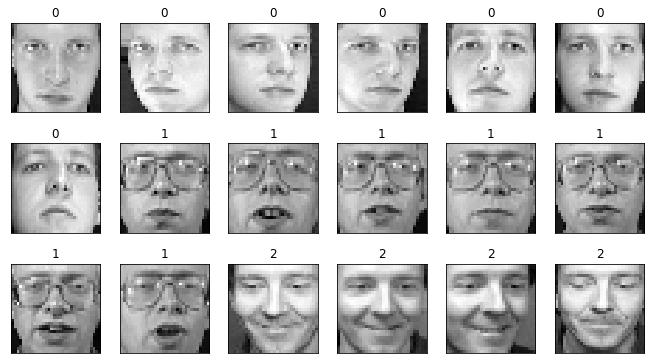

In [5]:
titles = [str(y[0]) for y in y_train]

plot_gallery(X_train, titles, image_h, image_w)

## Nearest Neighbour baseline

The simplest way to do face recognition is to treat raw pixels as features and perform **Nearest Neighbor Search** in the Euclidean space. Let's use **`KNeighborsClassifier`** class.

In [6]:
from sklearn.neighbors import KNeighborsClassifier as KNN

# Use KNeighborsClassifier to calculate test score for the Nearest Neighbour classifier.
from sklearn.metrics import accuracy_score

test_score = accuracy_score(y_test.flatten(), KNN().fit(X_train, y_train.flatten()).predict(X_test))

print('Test score: {}'.format(test_score))

Test score: 0.7833333333333333


Not very imperssive, is it?

Ну, иногда и ~~так сойдёт~~ это вполне неплохо.

## Eigenfaces

All the dirty work will be done by the scikit-learn package. First we need to learn a dictionary of codewords. For that we preprocess the training set by making each face normalized (zero mean and unit variance)..

In [7]:
X_train.mean(axis=1).shape

(280,)

In [8]:
# Populate variable 'X_train_processed' with samples each of which has zero mean and unit variance.
from sklearn import preprocessing

X_train_processed = preprocessing.scale(X_train, axis=1)
X_test_processed = preprocessing.scale(X_test, axis=1)

Now we are going to apply **PCA** to obtain a dictionary of codewords. 
**`RamdomizedPCA`** class is what we need.

In [9]:
from sklearn.decomposition import RandomizedPCA

n_components = 64

# Populate 'pca' with a trained instance of RamdomizedPCA.
pca = RandomizedPCA(n_components=n_components).fit(X_train_processed)

/home/alexsyrom/.virtualenvs/ml/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


We plot a bunch of principal components.

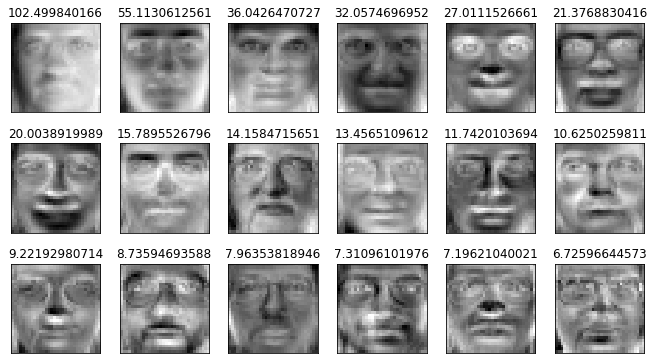

In [10]:
# Visualize principal components.
plot_gallery(pca.components_, pca.explained_variance_)

Transform training data, train an SVM and apply it to the encoded test data.

In [11]:
# Populate 'test_score' with test accuracy of an SVM classifier.

from sklearn.svm import SVC

test_score = accuracy_score(y_test.flatten(), SVC().\
                            fit(X_train_processed, y_train.flatten()).\
                            predict(X_test_processed))

print('Test score: {}'.format(test_score))

Test score: 0.8916666666666667


How many components are sufficient to reach the same accuracy level?

Max accuracy: 0.8916666666666667


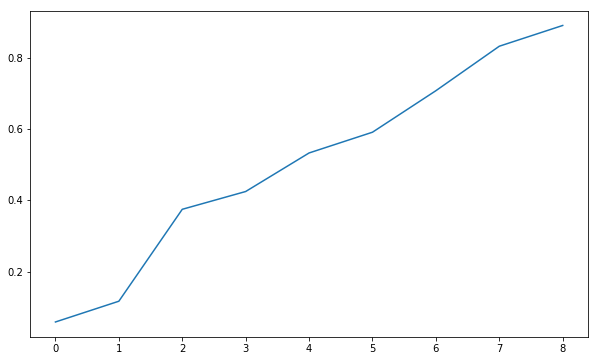

In [19]:
log_components = [i for i in range(9)]
n_components = [2 ** i for i in log_components]
accuracy = [0 for i in n_components]

# Try different numbers of components and populate 'accuracy' list.
for index, n in enumerate(n_components):
    pca = RandomizedPCA(n_components=n).fit(X_train_processed)
    X_train_red = pca.transform(X_train_processed)
    X_test_red = pca.transform(X_test_processed)
    accuracy[index] = accuracy_score(y_test.flatten(), SVC().\
                            fit(X_train_red, y_train.flatten()).\
                            predict(X_test_red))
    
plt.figure(figsize=(10, 6))
plt.plot(log_components, accuracy)

print('Max accuracy: {}'.format(max(accuracy)))

$2^8$ компонент уже достаточно. Так как изначальный размер картинки 32х32, то есть $2^{10}$, то мы безболезненно сократили количество признаков в четыре раза